# Transfer learning using Inception V3 model and STL-10 dataset 

In [1]:
import numpy as np
from sklearn.utils import shuffle
import pickle
from sklearn.cross_validation import train_test_split
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

/home/dawit/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
nb_classes = 10 #number of classes 
HEIGHT = 96
WIDTH = 96
DEPTH = 3
batch_size = 256
epochs =300

In [3]:
NB_IV3_LAYERS_TO_FREEZE =172
FC_SIZE = 1024
# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

In [4]:
train_X = []
train_Y = []
test_X = []
test_Y = []
train_path_X= './data/stl10_binary/train_X.bin'
train_path_Y = './data/stl10_binary/train_y.bin'
test_path_X = './data/stl10_binary/test_X.bin'
test_path_Y = './data/stl10_binary/test_y.bin'

In [5]:
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
    return images

In [6]:
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

In [7]:
train_X = read_all_images(train_path_X)
test_X = read_all_images(test_path_X)
train_Y= read_labels(train_path_Y)
test_Y = read_labels(test_path_Y)
      
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

train_X /= 255
test_X /= 255
train_Y = train_Y-1
test_Y = test_Y-1
# convert class vectors to binary class matrices
train_Y= np_utils.to_categorical(np.asarray(train_Y),10)
test_Y = np_utils.to_categorical(np.asarray(test_Y),10)


In [8]:
plt.imshow(train_X[6])
train_X.shape

(5000, 96, 96, 3)

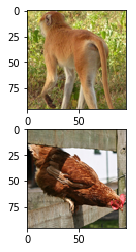

In [9]:
#visualizing sample data 

img1 = train_X[6]
img2 = test_X[6]

    
plt.subplot(211)
plt.imshow(img1)

plt.subplot(212)
plt.imshow(img2)
plt.show()

In [10]:
def setup_to_transfer_learn(model, base_model):
  """Freeze all layers and compile the model"""
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer=SGD(lr=1e-3, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


def add_new_last_layer(base_model, nb_classes):
  """Add last layer to the convnet
  Args:
    base_model: keras model excluding top
    nb_classes: # of classes
  Returns:
    new keras model with last layer
  """
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
  predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
  model = Model(input=base_model.input, output=predictions)
  return model


def setup_to_finetune(model):
  """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top layers.
  note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in the inceptionv3 arch
  Args:
    model: keras model
  """
  for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
     layer.trainable = False
  for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
     layer.trainable = True
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

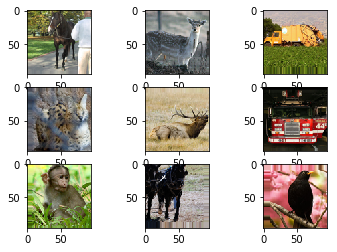

In [11]:
#creating 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
vertical_flip=False) # randomly flip images

for X_batch, y_batch in datagen.flow(train_X, train_Y, batch_size=batch_size):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i])
	# show the plot
	plt.show()
	break

In [12]:
datagen.fit(train_X)

In [15]:
base_model =  InceptionV3(weights='imagenet', include_top=False)
model = add_new_last_layer(base_model,nb_classes)
setup_to_transfer_learn(model, base_model)
#setup_to_finetune(model)

/home/dawit/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [ ]:
#With data agumentation 
hist=model.fit_generator(datagen.flow(train_X, train_Y,
                                     batch_size=250),
                        steps_per_epoch=train_X.shape[0] // 256,
                        epochs=100,
validation_data=(test_X, test_Y))



Epoch 1/100


In [16]:
#with out data agumentation

hist = model.fit(train_X, train_Y,
              batch_size=250,
              epochs=100,
              validation_data=(test_X, test_Y),
              shuffle=True)

Train on 5000 samples, validate on 8000 samples
Epoch 1/100
5000/5000 [==============================] - 496s - loss: 2.3450 - acc: 0.1034 - val_loss: 2.5601 - val_acc: 0.1343

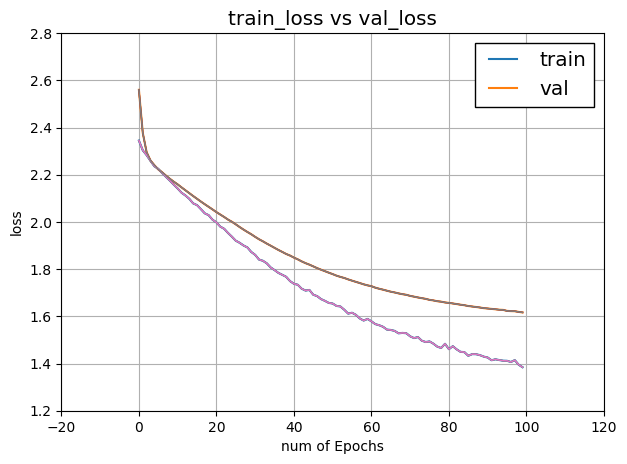

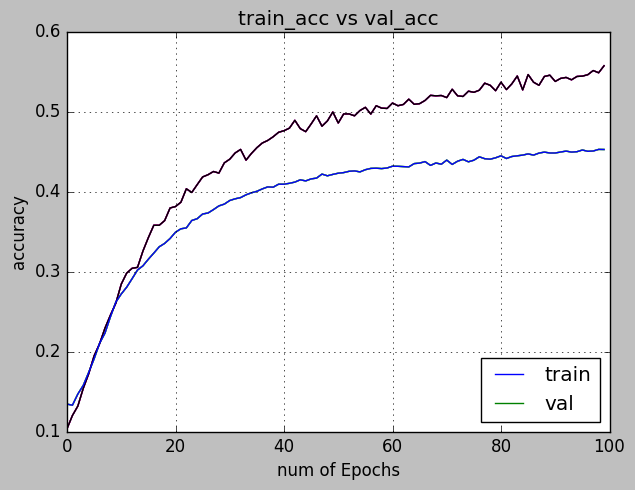

In [22]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']

xc=range(100)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.ylabel('accuracy')
plt.show()